 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:58235/notebooks/work/model-single-origin-samples/2.2%20informative%20priors.ipynb#A-modified-version-of-2.1.1-run+analysis-that-removes-training-data,-feeds-in-informative-priors,-and-works-on-the-same-test-mixtures" data-toc-modified-id="A-modified-version-of-2.1.1-run+analysis-that-removes-training-data,-feeds-in-informative-priors,-and-works-on-the-same-test-mixtures-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A modified version of 2.1.1 run+analysis that removes training data, feeds in informative priors, and works on the same test mixtures</a></span><ul class="toc-item"><li><span><a href="http://localhost:58235/notebooks/work/model-single-origin-samples/2.2%20informative%20priors.ipynb#Load-stan_data-that-was-fed-to-previous-Stan-fit.-And-load-in-stansummary-output-and-sampling-logs-from-previous-Stan-fit-so-we-can-create-informative-priors." data-toc-modified-id="Load-stan_data-that-was-fed-to-previous-Stan-fit.-And-load-in-stansummary-output-and-sampling-logs-from-previous-Stan-fit-so-we-can-create-informative-priors.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load <code>stan_data</code> that was fed to previous Stan fit. And load in <code>stansummary</code> output and sampling logs from previous Stan fit so we can create informative priors.</a></span></li></ul></li><li><span><a href="http://localhost:58235/notebooks/work/model-single-origin-samples/2.2%20informative%20priors.ipynb#Run-Stan." data-toc-modified-id="Run-Stan.-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run Stan.</a></span><ul class="toc-item"><li><span><a href="http://localhost:58235/notebooks/work/model-single-origin-samples/2.2%20informative%20priors.ipynb#Run-for-5-iters-with-&quot;set-equal-to-passed-in-data&quot;-paradigm" data-toc-modified-id="Run-for-5-iters-with-&quot;set-equal-to-passed-in-data&quot;-paradigm-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Run for 5 iters with "set equal to passed in data" paradigm</a></span></li></ul></li><li><span><a href="http://localhost:58235/notebooks/work/model-single-origin-samples/2.2%20informative%20priors.ipynb#Output-Stan-data-dictionary-with-informative-priors" data-toc-modified-id="Output-Stan-data-dictionary-with-informative-priors-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output Stan data dictionary with informative priors</a></span></li></ul></div>

# A modified version of 2.1.1 run+analysis that removes training data, feeds in informative priors, and works on the same test mixtures

In [1]:
import numpy as np
import matplotlib as mpl
import data
import models
import cache
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pystan
from time import time
from datetime import timedelta
import pickle
import dill

INFO:stancache.seed:Setting seed to 1245502385
INFO:root:Setting CACHE_DIR = /home/jovyan/modelcache/mz
INFO:stancache.seed:Setting seed to 1245502385


In [2]:
# verify kernel won't crash due to MKL issue from future imports
import sklearn.linear_model.tests.test_randomized_l1

In [3]:
model_name = 'model6.3'
by = 'SubSet'
total_num_genes = 800 # number we want to have total

In [31]:
sns.set_style('darkgrid')

## Load `stan_data` that was fed to previous Stan fit. And load in `stansummary` output and sampling logs from previous Stan fit so we can create informative priors.

In [4]:
stan_data = pickle.load(open('logs/2.1.1_standata.pkl', 'rb'))

In [5]:
stan_summary = pd.read_csv('logs/stansummary.newmarkergenes.csv', comment='#')
stan_summary.head()

name          Mean          MCSE        StdDev            5%  \
0           lp__ -2.733760e+12  2.655400e+12  5.958230e+13  2.104990e+08   
1  accept_stat__  7.683410e-01  5.586460e-02  2.688980e-01  1.066180e-01   
2     stepsize__  1.210910e-02  4.257620e-03  3.261320e-01  1.589870e-03   
3    treedepth__  9.535880e+00  1.559470e-01  1.676400e+00  6.000000e+00   
4   n_leapfrog__  9.339530e+02  3.137040e+01  2.570340e+02  1.100000e+02   

            50%           95%      N_Eff   N_Eff/s     R_hat  
0  2.105030e+08  2.105040e+08   503.4730  0.001378  1.004900  
1  8.800830e-01  9.979510e-01    23.1686  0.000063  1.156870  
2  3.033560e-03  7.906290e-03  5867.5000  0.016058  0.999992  
3  1.000000e+01  1.000000e+01   115.5590  0.000316  1.025040  
4  1.023000e+03  1.023000e+03    67.1336  0.000184  1.042100

In [6]:
stan_summary[stan_summary.name.str.startswith('theta_mu')]

name      Mean      MCSE    StdDev        5%       50%  \
10563   theta_mu[1]  3.319600  0.058029  1.056600  1.741490  3.387090   
10564   theta_mu[2]  4.036800  0.063131  1.142390  2.189280  4.107740   
10565   theta_mu[3]  2.377710  0.050414  0.983641  0.844940  2.437870   
10566   theta_mu[4]  1.975680  0.045298  0.947613  0.410948  2.024150   
10567   theta_mu[5]  3.876520  0.059385  1.007430  2.443590  3.966470   
10568   theta_mu[6] -0.841811  0.059385  0.909945 -2.308380 -0.832525   
10569   theta_mu[7]  1.758610  0.029958  0.856072  0.321260  1.777680   
10570   theta_mu[8] -1.967850  0.035162  0.839948 -3.346690 -1.979210   
10571   theta_mu[9] -0.657816  0.019412  0.775878 -1.918470 -0.665555   
10572  theta_mu[10]  0.426341  0.024851  0.789938 -0.854144  0.431562   
10573  theta_mu[11]  2.809710  0.047227  0.988896  1.207510  2.871860   
10574  theta_mu[12]  5.475980  0.107462  1.334300  3.909350  5.641570   
10575  theta_mu[13]  1.200000  0.030268  0.902630 -0.275386  1.198680   

            95%     N_Eff   N_Eff/s    R_hat  
10563  4.823910   331.533  0.000907  1.00895  
10564  5.741740   327.447  0.000896  1.01997  
10565  3.811940   380.695  0.001042  1.00481  
10566  3.407360   437.633  0.001198  1.00601  
10567  5.266720   287.785  0.000788  1.00772  
10568  0.670014   234.792  0.000643  1.01462  
10569  3.111870   816.567  0.002235  1.00305  
10570 -0.579104   570.638  0.001562  1.00671  
10571  0.626703  1597.490  0.004372  1.00168  
10572  1.718910  1010.370  0.002765  1.00201  
10573  4.293830   438.444  0.001200  1.00807  
10574  7.013120   154.170  0.000422  1.02110  
10575  2.666490   889.337  0.002434  1.00469

A list of the parameters we want to create (see `model6.3[...].stan`)

```
    vector[C] theta_mu_mu; // mean of normal distribution
    vector[C] theta_mu_std; // standard deviation of normal distribution
    vector[C] theta_coefs_raw_mu;
    vector[C] theta_coefs_raw_std;
    vector[C] Omega_sigma_mu;
    vector[C] Omega_sigma_std;
    matrix[C, C] Omega_L_mu;
    matrix[C, C] Omega_L_std;
    matrix[G, M] theta_coefs_per_gene_mu;
    matrix[G, M] theta_coefs_per_gene_std;
    vector[G] log_gene_base_mu;
    vector[G] log_gene_base_std;
    vector[G] gene_phi_mu;
    vector[G] gene_phi_std;
```

In [7]:
# vectors

theta_mu_mu = stan_summary[stan_summary.name.str.startswith('theta_mu')]['Mean'].values
theta_mu_std = stan_summary[stan_summary.name.str.startswith('theta_mu')]['StdDev'].values

theta_coefs_raw_mu = stan_summary[stan_summary.name.str.startswith('theta_coefs_raw')]['Mean'].values
theta_coefs_raw_std = stan_summary[stan_summary.name.str.startswith('theta_coefs_raw')]['StdDev'].values

Omega_sigma_mu = stan_summary[stan_summary.name.str.startswith('Omega_sigma')]['Mean'].values
Omega_sigma_std = stan_summary[stan_summary.name.str.startswith('Omega_sigma')]['StdDev'].values

log_gene_base_mu = stan_summary[stan_summary.name.str.startswith('log_gene_base')]['Mean'].values
log_gene_base_std = stan_summary[stan_summary.name.str.startswith('log_gene_base')]['StdDev'].values

gene_phi_mu = stan_summary[stan_summary.name.str.startswith('gene_phi')]['Mean'].values
gene_phi_std = stan_summary[stan_summary.name.str.startswith('gene_phi')]['StdDev'].values

In [8]:
# matrices

print(stan_data['C'], stan_data['M'], stan_data['G'])



13 20 798


In [9]:
stan_summary[stan_summary.name.str.startswith('theta_coefs_per_gene')]

name      Mean      MCSE    StdDev       5%  \
10596     theta_coefs_per_gene[1,1]  0.036470  0.018183  0.961394 -1.52702   
10597     theta_coefs_per_gene[1,2] -0.523690  0.021059  0.904338 -2.02419   
10598     theta_coefs_per_gene[1,3]  0.026794  0.020821  0.895426 -1.49504   
10599     theta_coefs_per_gene[1,4]  0.143908  0.021846  0.904487 -1.32652   
10600     theta_coefs_per_gene[1,5]  0.044163  0.022658  0.966304 -1.56625   
10601     theta_coefs_per_gene[1,6]  0.343176  0.022139  0.923113 -1.16949   
10602     theta_coefs_per_gene[1,7]  0.110170  0.019489  0.902915 -1.35319   
10603     theta_coefs_per_gene[1,8]  0.166240  0.023993  0.897562 -1.29853   
10604     theta_coefs_per_gene[1,9]  0.036639  0.018386  0.876258 -1.37465   
10605    theta_coefs_per_gene[1,10] -0.007117  0.022576  0.856373 -1.44487   
10606    theta_coefs_per_gene[1,11] -0.287575  0.030882  0.983417 -1.90930   
10607    theta_coefs_per_gene[1,12] -0.196095  0.022054  0.924290 -1.69644   
10608    theta_coefs_per_gene[1,13] -0.164082  0.017122  0.912285 -1.66554   
10609    theta_coefs_per_gene[1,14] -0.268834  0.022720  0.939356 -1.83710   
10610    theta_coefs_per_gene[1,15]  0.147041  0.025572  0.994348 -1.53165   
10611    theta_coefs_per_gene[1,16]  0.149969  0.021038  0.907636 -1.39425   
10612    theta_coefs_per_gene[1,17] -0.250050  0.025152  0.961819 -1.83885   
10613    theta_coefs_per_gene[1,18] -0.014224  0.021075  1.005770 -1.67529   
10614    theta_coefs_per_gene[1,19]  0.049791  0.025618  0.900382 -1.39057   
10615    theta_coefs_per_gene[1,20]  0.052962  0.024789  0.972262 -1.56434   
10616     theta_coefs_per_gene[2,1] -0.007581  0.019214  0.975668 -1.65063   
10617     theta_coefs_per_gene[2,2]  0.314208  0.018931  0.984307 -1.33699   
10618     theta_coefs_per_gene[2,3]  0.137279  0.023535  0.984178 -1.53887   
10619     theta_coefs_per_gene[2,4] -0.124653  0.024570  1.001090 -1.79385   
10620     theta_coefs_per_gene[2,5] -0.040097  0.021123  0.993210 -1.71316   
10621     theta_coefs_per_gene[2,6] -0.216267  0.024188  0.993310 -1.83096   
10622     theta_coefs_per_gene[2,7] -0.076003  0.020073  0.986929 -1.72397   
10623     theta_coefs_per_gene[2,8] -0.099998  0.019690  0.994725 -1.74547   
10624     theta_coefs_per_gene[2,9] -0.089850  0.027105  1.000410 -1.80088   
10625    theta_coefs_per_gene[2,10] -0.327727  0.025667  0.984931 -1.92382   
...                             ...       ...       ...       ...      ...   
26526  theta_coefs_per_gene[797,11]  0.064183  0.023356  1.008970 -1.59786   
26527  theta_coefs_per_gene[797,12] -0.043230  0.029953  1.017380 -1.70248   
26528  theta_coefs_per_gene[797,13] -0.091269  0.022138  0.995300 -1.70323   
26529  theta_coefs_per_gene[797,14]  0.102629  0.028789  1.008290 -1.52452   
26530  theta_coefs_per_gene[797,15]  0.033804  0.018807  0.970521 -1.57792   
26531  theta_coefs_per_gene[797,16]  0.040417  0.021227  0.978390 -1.59947   
26532  theta_coefs_per_gene[797,17]  0.095079  0.018812  1.000300 -1.62270   
26533  theta_coefs_per_gene[797,18]  0.040827  0.025885  1.021710 -1.69913   
26534  theta_coefs_per_gene[797,19] -0.072865  0.021207  1.000590 -1.71761   
26535  theta_coefs_per_gene[797,20] -0.007351  0.026118  1.015150 -1.62817   
26536   theta_coefs_per_gene[798,1]  0.040794  0.025824  1.030350 -1.70100   
26537   theta_coefs_per_gene[798,2]  0.007484  0.021824  1.011320 -1.63741   
26538   theta_coefs_per_gene[798,3]  0.075941  0.019629  0.985753 -1.57713   
26539   theta_coefs_per_gene[798,4]  0.032622  0.019976  1.000310 -1.53688   
26540   theta_coefs_per_gene[798,5]  0.078536  0.020303  1.007800 -1.58736   
26541   theta_coefs_per_gene[798,6]  0.026525  0.023242  0.996621 -1.64752   
26542   theta_coefs_per_gene[798,7]  0.010231  0.022579  1.002650 -1.66240   
26543   theta_coefs_per_gene[798,8]  0.164288  0.020350  0.982219 -1.43008   
26544   theta_coefs_per_gene[798,9]  0.030340  0.023358  1.008220 -1.63147   
26545  theta_coefs_per_gene[798,10] -0.149690  0.0247

In [10]:
theta_coefs_per_gene_mu = stan_summary[stan_summary.name.str.startswith('theta_coefs_per_gene')]['Mean'].values.reshape((stan_data['G'], stan_data['M']))
theta_coefs_per_gene_mu.shape

(798, 20)

In [11]:
theta_coefs_per_gene_mu

array([[ 0.0364697 , -0.52369   ,  0.0267939 , ..., -0.0142241 ,
         0.0497913 ,  0.0529621 ],
       [-0.00758093,  0.314208  ,  0.137279  , ..., -0.272628  ,
         0.00096085, -0.286428  ],
       [ 0.169287  , -0.102975  , -0.194124  , ...,  0.116318  ,
         0.0399172 ,  0.270065  ],
       ..., 
       [ 0.0579485 , -0.108801  ,  0.0175063 , ...,  0.0485307 ,
         0.0355954 ,  0.0957599 ],
       [ 0.00832523,  0.0226765 , -0.0951435 , ...,  0.0408273 ,
        -0.0728646 , -0.0073514 ],
       [ 0.0407945 ,  0.00748403,  0.0759409 , ...,  0.0386369 ,
        -0.15184   ,  0.0890657 ]])

In [12]:
theta_coefs_per_gene_std = stan_summary[stan_summary.name.str.startswith('theta_coefs_per_gene')]['StdDev'].values.reshape((stan_data['G'], stan_data['M']))

In [13]:
#Omega_L_mu = stan_summary[stan_summary.name.str.startswith('Omega_L')]['Mean'].values.reshape((stan_data['C'], stan_data['C']))
#Omega_L_std = stan_summary[stan_summary.name.str.startswith('Omega_L')]['StdDev'].values.reshape((stan_data['C'], stan_data['C']))
# that leads to "RuntimeError: Initialization failed." below

# Omega_L must be a valid correlation matrix. the means might not form a valid correlation matrix
# instead, choose an iteration's values for Omega_L that are closest to the means
Omega_L_std = stan_summary[stan_summary.name.str.startswith('Omega_L')]['StdDev'].values.reshape((stan_data['C'], stan_data['C']))
Omega_L_means = stan_summary[stan_summary.name.str.startswith('Omega_L')]['Mean'].values.reshape((stan_data['C'], stan_data['C']))
Omega_L_means.shape

(13, 13)

`Omega_L` is a special case because it's a correlation matrix. We can't just feed in means, because they might not form a positive semidefinite matrix. So let's extract one iteration's values of `Omega_L` from the raw sampling logs. We'll chose the iteration that's closest to the means.

In [14]:
cols_we_want = stan_summary[stan_summary.name.str.startswith('Omega_L')]['name'].values
cols_we_want

array(['Omega_L[1,1]', 'Omega_L[1,2]', 'Omega_L[1,3]', 'Omega_L[1,4]',
       'Omega_L[1,5]', 'Omega_L[1,6]', 'Omega_L[1,7]', 'Omega_L[1,8]',
       'Omega_L[1,9]', 'Omega_L[1,10]', 'Omega_L[1,11]', 'Omega_L[1,12]',
       'Omega_L[1,13]', 'Omega_L[2,1]', 'Omega_L[2,2]', 'Omega_L[2,3]',
       'Omega_L[2,4]', 'Omega_L[2,5]', 'Omega_L[2,6]', 'Omega_L[2,7]',
       'Omega_L[2,8]', 'Omega_L[2,9]', 'Omega_L[2,10]', 'Omega_L[2,11]',
       'Omega_L[2,12]', 'Omega_L[2,13]', 'Omega_L[3,1]', 'Omega_L[3,2]',
       'Omega_L[3,3]', 'Omega_L[3,4]', 'Omega_L[3,5]', 'Omega_L[3,6]',
       'Omega_L[3,7]', 'Omega_L[3,8]', 'Omega_L[3,9]', 'Omega_L[3,10]',
       'Omega_L[3,11]', 'Omega_L[3,12]', 'Omega_L[3,13]', 'Omega_L[4,1]',
       'Omega_L[4,2]', 'Omega_L[4,3]', 'Omega_L[4,4]', 'Omega_L[4,5]',
       'Omega_L[4,6]', 'Omega_L[4,7]', 'Omega_L[4,8]', 'Omega_L[4,9]',
       'Omega_L[4,10]', 'Omega_L[4,11]', 'Omega_L[4,12]', 'Omega_L[4,13]',
       'Omega_L[5,1]', 'Omega_L[5,2]', 'Omega_L[5,3]', 'Omega

In [15]:
cols_we_want_renamed  = [c.replace('[', '.').replace(']', '').replace(',', '.') for c in cols_we_want]
cols_we_want_renamed

['Omega_L.1.1',
 'Omega_L.1.2',
 'Omega_L.1.3',
 'Omega_L.1.4',
 'Omega_L.1.5',
 'Omega_L.1.6',
 'Omega_L.1.7',
 'Omega_L.1.8',
 'Omega_L.1.9',
 'Omega_L.1.10',
 'Omega_L.1.11',
 'Omega_L.1.12',
 'Omega_L.1.13',
 'Omega_L.2.1',
 'Omega_L.2.2',
 'Omega_L.2.3',
 'Omega_L.2.4',
 'Omega_L.2.5',
 'Omega_L.2.6',
 'Omega_L.2.7',
 'Omega_L.2.8',
 'Omega_L.2.9',
 'Omega_L.2.10',
 'Omega_L.2.11',
 'Omega_L.2.12',
 'Omega_L.2.13',
 'Omega_L.3.1',
 'Omega_L.3.2',
 'Omega_L.3.3',
 'Omega_L.3.4',
 'Omega_L.3.5',
 'Omega_L.3.6',
 'Omega_L.3.7',
 'Omega_L.3.8',
 'Omega_L.3.9',
 'Omega_L.3.10',
 'Omega_L.3.11',
 'Omega_L.3.12',
 'Omega_L.3.13',
 'Omega_L.4.1',
 'Omega_L.4.2',
 'Omega_L.4.3',
 'Omega_L.4.4',
 'Omega_L.4.5',
 'Omega_L.4.6',
 'Omega_L.4.7',
 'Omega_L.4.8',
 'Omega_L.4.9',
 'Omega_L.4.10',
 'Omega_L.4.11',
 'Omega_L.4.12',
 'Omega_L.4.13',
 'Omega_L.5.1',
 'Omega_L.5.2',
 'Omega_L.5.3',
 'Omega_L.5.4',
 'Omega_L.5.5',
 'Omega_L.5.6',
 'Omega_L.5.7',
 'Omega_L.5.8',
 'Omega_L.5.9',
 'Omega_

In [16]:
all_traces = []
for i in range(4):
    print('loading:', i)
    trace_i = pd.read_csv('logs/newmarkergenes_sampling_log.txt_%d.csv' % i, comment='#', usecols=cols_we_want_renamed)
    trace_i['trace_id'] = i
    trace_i['iter'] = trace_i.index
    all_traces.append(trace_i)

loading: 0
loading: 1
loading: 2
loading: 3


In [17]:
all_traces_df = pd.concat(all_traces)
print(all_traces_df.shape)
all_traces_df.head()

(8000, 171)


Omega_L.1.1  Omega_L.2.1  Omega_L.3.1  Omega_L.4.1  Omega_L.5.1  \
0            1     0.951784    -0.922494     0.463042     0.003904   
1            1     0.951784    -0.922494     0.463042     0.003904   
2            1     0.951784    -0.922494     0.463042     0.003904   
3            1     0.951784    -0.922494     0.463042     0.003904   
4            1     0.951784    -0.922494     0.463042     0.003904   

   Omega_L.6.1  Omega_L.7.1  Omega_L.8.1  Omega_L.9.1  Omega_L.10.1  ...   \
0    -0.044782    -0.893575     0.786217      0.45183      0.769789  ...    
1    -0.044782    -0.893575     0.786217      0.45183      0.769789  ...    
2    -0.044782    -0.893575     0.786217      0.45183      0.769789  ...    
3    -0.044782    -0.893575     0.786217      0.45183      0.769789  ...    
4    -0.044782    -0.893575     0.786217      0.45183      0.769789  ...    

   Omega_L.6.13  Omega_L.7.13  Omega_L.8.13  Omega_L.9.13  Omega_L.10.13  \
0             0             0             0             0              0   
1             0             0             0             0              0   
2             0             0             0             0              0   
3             0             0             0             0              0   
4             0             0             0             0              0   

   Omega_L.11.13  Omega_L.12.13  Omega_L.13.13  trace_id  iter  
0              0              0       0.001532         0     0  
1              0              0       0.001532         0     1  
2              0              0       0.001532         0     2  
3              0              0       0.001532         0     3  
4              0              0       0.001532         0     4  

[5 rows x 171 columns]

In [18]:
all_traces_df2 = pd.melt(all_traces_df, id_vars=['iter','trace_id'], value_name='estimate', var_name='variable')
all_traces_df2.head()

iter  trace_id     variable  estimate
0     0         0  Omega_L.1.1       1.0
1     1         0  Omega_L.1.1       1.0
2     2         0  Omega_L.1.1       1.0
3     3         0  Omega_L.1.1       1.0
4     4         0  Omega_L.1.1       1.0

In [19]:
var_ids = all_traces_df2.variable.str.extract('Omega_L.(?P<class1>\d+).(?P<class2>\d+)')
var_ids.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':


class1 class2
0      1      1
1      1      1
2      1      1
3      1      1
4      1      1

In [20]:
all_traces_df3= pd.concat([all_traces_df2, var_ids], axis=1) 
all_traces_df3.head()

iter  trace_id     variable  estimate class1 class2
0     0         0  Omega_L.1.1       1.0      1      1
1     1         0  Omega_L.1.1       1.0      1      1
2     2         0  Omega_L.1.1       1.0      1      1
3     3         0  Omega_L.1.1       1.0      1      1
4     4         0  Omega_L.1.1       1.0      1      1

In [21]:
all_traces_df3['class1'] = all_traces_df3['class1'].astype(int)
all_traces_df3['class2'] = all_traces_df3['class2'].astype(int)

In [22]:
# Omega_L[12,6]
#all_traces_df3['orig_colname'] = all_traces_df3.apply(lambda row: 'Omega_L[%d,%d]' % (row['class1'], row['class2']), axis=1)
#all_traces_df3.orig_colname.head()

In [23]:
# drop warmups (very important! stansummary does this automatically, btw.)
print(all_traces_df3.iter.describe()[['min', 'max']])
all_traces_df3 = all_traces_df3.loc[all_traces_df3['iter']>=1000,]
all_traces_df3['iter'] -= 1000
# this should be better now
#all_traces_df3.iter.hist()
all_traces_df3.iter.describe()[['min', 'max']]

min       0.0
max    1999.0
Name: iter, dtype: float64


min      0.0
max    999.0
Name: iter, dtype: float64

In [24]:
all_traces_df3.head()

iter  trace_id     variable  estimate  class1  class2
1000     0         0  Omega_L.1.1       1.0       1       1
1001     1         0  Omega_L.1.1       1.0       1       1
1002     2         0  Omega_L.1.1       1.0       1       1
1003     3         0  Omega_L.1.1       1.0       1       1
1004     4         0  Omega_L.1.1       1.0       1       1

In [25]:
all_traces_df3['mean'] = Omega_L_means[all_traces_df3['class1']-1, all_traces_df3['class2']-1]

In [26]:
all_traces_df3.tail()

iter  trace_id       variable  estimate  class1  class2      mean
1351995   995         3  Omega_L.13.13  0.029559      13      13  0.049494
1351996   996         3  Omega_L.13.13  0.028405      13      13  0.049494
1351997   997         3  Omega_L.13.13  0.027599      13      13  0.049494
1351998   998         3  Omega_L.13.13  0.034898      13      13  0.049494
1351999   999         3  Omega_L.13.13  0.044292      13      13  0.049494

In [27]:
Omega_L_means[13-1, 13-1]

0.049493599999999999

In [28]:
Omega_L_means.shape

(13, 13)

In [29]:
# subtract estimate (individual iteration value) from mean for each row
all_traces_df3['diff_from_mean'] = np.abs(all_traces_df3['estimate'] - all_traces_df3['mean'])

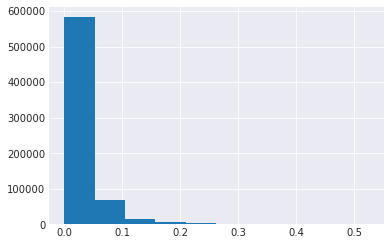

In [32]:
all_traces_df3.diff_from_mean.hist()

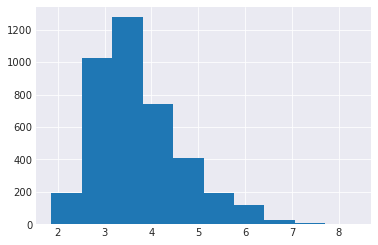

In [33]:
# group by iter,trace_id, sum all variables' differences from mean
quality_of_each_iter = all_traces_df3.groupby(['trace_id', 'iter'])['diff_from_mean'].sum()
quality_of_each_iter.hist()

In [34]:
quality_of_each_iter.min()

1.8663715999999999

In [35]:
quality_of_each_iter.argmin()

(3, 68)

In [36]:
all_traces_df3[(all_traces_df3['trace_id'] == quality_of_each_iter.argmin()[0]) & (all_traces_df3['iter'] == quality_of_each_iter.argmin()[1])].diff_from_mean.sum()

1.8663715999999999

In [37]:
all_traces_df3[(all_traces_df3['trace_id'] == quality_of_each_iter.argmin()[0]) & (all_traces_df3['iter'] == quality_of_each_iter.argmin()[1])]

iter  trace_id       variable  estimate  class1  class2      mean  \
7068       68         3    Omega_L.1.1  1.000000       1       1  1.000000   
15068      68         3    Omega_L.2.1  0.954243       2       1  0.933631   
23068      68         3    Omega_L.3.1  0.960364       3       1  0.934306   
31068      68         3    Omega_L.4.1  0.332703       4       1  0.327230   
39068      68         3    Omega_L.5.1  0.245395       5       1  0.253712   
47068      68         3    Omega_L.6.1  0.334823       6       1  0.310774   
55068      68         3    Omega_L.7.1  0.309229       7       1  0.293183   
63068      68         3    Omega_L.8.1  0.248150       8       1  0.232115   
71068      68         3    Omega_L.9.1  0.258964       9       1  0.219261   
79068      68         3   Omega_L.10.1  0.280491      10       1  0.294359   
87068      68         3   Omega_L.11.1  0.280306      11       1  0.298074   
95068      68         3   Omega_L.12.1  0.163913      12       1  0.163747   
103068     68         3   Omega_L.13.1  0.274957      13       1  0.268993   
111068     68         3    Omega_L.1.2  0.000000       1       2  0.000000   
119068     68         3    Omega_L.2.2  0.299033       2       2  0.318509   
127068     68         3    Omega_L.3.2  0.273233       3       2  0.266892   
135068     68         3    Omega_L.4.2  0.544931       4       2  0.530825   
143068     68         3    Omega_L.5.2  0.555957       5       2  0.562895   
151068     68         3    Omega_L.6.2  0.515024       6       2  0.505293   
159068     68         3    Omega_L.7.2  0.498365       7       2  0.488068   
167068     68         3    Omega_L.8.2  0.556431       8       2  0.528171   
175068     68         3    Omega_L.9.2  0.532782       9       2  0.539084   
183068     68         3   Omega_L.10.2  0.471615      10       2  0.454255   
191068     68         3   Omega_L.11.2  0.546851      11       2  0.549405   
199068     68         3   Omega_L.12.2  0.375484      12       2  0.394556   
207068     68         3   Omega_L.13.2  0.524134      13       2  0.510946   
215068     68         3    Omega_L.1.3  0.000000       1       3  0.000000   
223068     68         3    Omega_L.2.3  0.000000       2       3  0.000000   
231068     68         3    Omega_L.3.3  0.055169       3       3  0.065518   
239068     68         3    Omega_L.4.3  0.094709       4       3  0.077423   
...       ...       ...            ...       ...     ...     ...       ...   
1119068    68         3  Omega_L.10.11  0.000000      10      11  0.000000   
1127068    68         3  Omega_L.11.11  0.049566      11      11  0.058212   
1135068    68         3  Omega_L.12.11  0.073048      12      11  0.053588   
1143068    68         3  Omega_L.13.11  0.027159      13      11  0.032306   
1151068    68         3   Omega_L.1.12  0.000000       1      12  0.000000   
1159068    68         3   Omega_L.2.12  0.000000       2      12  0.000000   
1167068    68         3   Omega_L.3.12  0.000000       3      12  0.000000   
1175068    68         3   Omega_L.4.12  0.000000       4      12  0.000000   
1183068    68         3   Omega_L.5.12  0.000000       5      12  0.000000   
1191068    68         3   Omega_L.6.12  0.000000       6      12  0.000000   
1199068    68         3   Omega_L.7.12  0.000000       7      12  0.000000   
1207068    68         3   Omega_L.8.12  0.000000       8      12  0.000000   
1215068    68         3   Omega_L.9.12  0.000000       9      12  0.000000   
1223068    68         3  Omega_L.10.12  0.000000      10      12  0.000000   
1231068    68         3  Omega_L.11.12  0.000000      11      12  0.000000   
1239068    68         3  Omega_L.12.12  0.060442      12      12  0.077100   
1247068    68         3  Omega_L.13.12 -0.012200      13      12  0.016214   
1255068    68         3   Omega_L.1.13  0.000000       1      13  0.000000   
1263068    68         3   Omega_L.2.13  0.000000       2      13  0.000000   
1271068    68         3   Omega

In [38]:
Omega_L_mu = all_traces_df3[(all_traces_df3['trace_id'] == quality_of_each_iter.argmin()[0]) & (all_traces_df3['iter'] == quality_of_each_iter.argmin()[1])]\
['estimate'].values.reshape((stan_data['C'], stan_data['C']))
Omega_L_mu.shape

(13, 13)

`Omega_L_mu` is one iteration's value of `Omega_L`.

# Run Stan.

In [39]:
model_file = models.get_model_file(model_name=model_name)
model_file

'models/model6.3_negbinom_matrix_correlation_features_oos_optim_informativepriors.stan'

In [40]:
stan_data.keys()

dict_keys(['N', 'G', 'S', 'C', 'gene', 'sample', 'x', 'y', 'cell_features', 'M', 'N2', 'S2', 'gene2', 'sample2', 'y2', 'x2'])

In [41]:
# delete unneeded keys
for k in ['gene', 'sample', 'x', 'y', 'N', 'S']:
    stan_data.pop(k, None)

In [42]:
stan_data.keys()

dict_keys(['G', 'C', 'cell_features', 'M', 'N2', 'S2', 'gene2', 'sample2', 'y2', 'x2'])

In [43]:
# inject our data
informative_priors = {
    'theta_mu_mu': theta_mu_mu, 
    'theta_mu_std': theta_mu_std, 
    'theta_coefs_raw_mu': theta_coefs_raw_mu, 
    'theta_coefs_raw_std': theta_coefs_raw_std, 
    'Omega_sigma_mu': Omega_sigma_mu, 
    'Omega_sigma_std': Omega_sigma_std, 
    'log_gene_base_mu': log_gene_base_mu, 
    'log_gene_base_std': log_gene_base_std, 
    'gene_phi_mu': gene_phi_mu, 
    'gene_phi_std': gene_phi_std, 
    'theta_coefs_per_gene_mu': theta_coefs_per_gene_mu,
    'theta_coefs_per_gene_std': theta_coefs_per_gene_std,
    'Omega_L_mu': Omega_L_mu,
    'Omega_L_std': Omega_L_std
}

In [44]:
stan_data.update(informative_priors)

In [45]:
stan_data.keys()

dict_keys(['G', 'C', 'cell_features', 'M', 'N2', 'S2', 'gene2', 'sample2', 'y2', 'x2', 'theta_mu_mu', 'theta_mu_std', 'theta_coefs_raw_mu', 'theta_coefs_raw_std', 'Omega_sigma_mu', 'Omega_sigma_std', 'log_gene_base_mu', 'log_gene_base_std', 'gene_phi_mu', 'gene_phi_std', 'theta_coefs_per_gene_mu', 'theta_coefs_per_gene_std', 'Omega_L_mu', 'Omega_L_std'])

In [230]:
model_codetmp = open(model_file, 'r').read()
print(pystan.stan(model_code=model_codetmp, data=stan_data, iter=1, chains=1, verbose=True))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b07e1063999ce7451a2bd7937b731c24 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 | packaged by conda-forge | (default, Jan 12 2017, 00:06:14) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.25.2


Compiling /tmp/tmpud1p_23p/stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_9202568934837409861.pyx because it changed.
[1/1] Cythonizing /tmp/tmpud1p_23p/stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_9202568934837409861.pyx
building 'stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_9202568934837409861' extension
creating /tmp/tmpud1p_23p/tmp
creating /tmp/tmpud1p_23p/tmp/tmpud1p_23p
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpud1p_23p -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.62.0 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib

RuntimeError: Initialization failed.

I dug into the console (`docker logs ...`) and saw:
```
Rejecting initial value:
  Error evaluating the log probability at the initial value.
Exception: normal_lpdf: Scale parameter[2] is 0, but must be > 0!  (in 'unkown file name' at line 84)
```

The relevant line:
```
    for (c in 1:C) {
        Omega_L[c] ~ normal(Omega_L_mu[c], Omega_L_std[c]);
    }
```

I think we are passing in standard deviation 0 somewhere. Let's confirm:

In [46]:
Omega_L_std.min()

0.0

Choose some non-zero tiny standard deviation for our most informative priors (for all `_std`, not just `Omega_L_std`):

In [47]:
def_objs = locals().keys()
to_zero_correct = [k for k in def_objs if '_std' in k]
to_zero_correct

['theta_mu_std',
 'theta_coefs_raw_std',
 'Omega_sigma_std',
 'log_gene_base_std',
 'gene_phi_std',
 'theta_coefs_per_gene_std',
 'Omega_L_std']

In [48]:
for i in to_zero_correct:
    print(i, eval(i).min())

theta_mu_std 0.775878
theta_coefs_raw_std 0.825214
Omega_sigma_std 2.17884
log_gene_base_std 0.299103
gene_phi_std 0.0559549
theta_coefs_per_gene_std 0.814661
Omega_L_std 0.0


In [49]:
for i in to_zero_correct:
    if eval(i).min() == 0.0:
        print(i)
        exec("%s[%s == 0.0] = 0.00001" % (i,i))

Omega_L_std


In [50]:
for i in to_zero_correct:
    print(i, eval(i).min())

theta_mu_std 0.775878
theta_coefs_raw_std 0.825214
Omega_sigma_std 2.17884
log_gene_base_std 0.299103
gene_phi_std 0.0559549
theta_coefs_per_gene_std 0.814661
Omega_L_std 5.47374e-14


In [51]:
for i in to_zero_correct:
    assert eval(i).min() > 0.

In [250]:
# inject our data
informative_priors = {
    'theta_mu_mu': theta_mu_mu, 
    'theta_mu_std': theta_mu_std, 
    'theta_coefs_raw_mu': theta_coefs_raw_mu, 
    'theta_coefs_raw_std': theta_coefs_raw_std, 
    'Omega_sigma_mu': Omega_sigma_mu, 
    'Omega_sigma_std': Omega_sigma_std, 
    'log_gene_base_mu': log_gene_base_mu, 
    'log_gene_base_std': log_gene_base_std, 
    'gene_phi_mu': gene_phi_mu, 
    'gene_phi_std': gene_phi_std, 
    'theta_coefs_per_gene_mu': theta_coefs_per_gene_mu,
    'theta_coefs_per_gene_std': theta_coefs_per_gene_std,
    'Omega_L_mu': Omega_L_mu,
    'Omega_L_std': Omega_L_std
}

stan_data.update(informative_priors)

model_codetmp = open(model_file, 'r').read()

print(pystan.stan(model_code=model_codetmp, data=stan_data, iter=1, chains=1, verbose=True))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b07e1063999ce7451a2bd7937b731c24 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 | packaged by conda-forge | (default, Jan 12 2017, 00:06:14) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.25.2


Compiling /tmp/tmpedc9g_oe/stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_3868636414872311756.pyx because it changed.
[1/1] Cythonizing /tmp/tmpedc9g_oe/stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_3868636414872311756.pyx
building 'stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_3868636414872311756' extension
creating /tmp/tmpedc9g_oe/tmp
creating /tmp/tmpedc9g_oe/tmp/tmpedc9g_oe
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpedc9g_oe -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.62.0 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: float division

Associated console message:

```
Iteration: 1 / 1 [100%]  (Sampling)
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Log location parameter[1] is -nan, but must be finite!  (in 'unkown file name' at line 106)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.


 Elapsed Time: 6e-06 seconds (Warm-up)
               0.039139 seconds (Sampling)
               0.039145 seconds (Total)
```

Also had earlier in console:

```
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Log location parameter[1] is inf, but must be finite!  (in 'unkown file name' at line 106)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Log location parameter[11] is inf, but must be finite!  (in 'unkown file name' at line 106)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_log_lpmf: Log location parameter[33] is inf, but must be finite!  (in 'unkown file name' at line 106)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
```

Related to this part of model:
```
    for (s in 1:S2) {
        vector[G] log_expected_rate;
        log_expected_rate = log_gene_base + log(theta*sample2_x[s]);
        sample2_y[s] ~ neg_binomial_2_log(log_expected_rate, gene_phi);
    }
```


In [66]:
model_file

'models/model6.3_negbinom_matrix_correlation_features_oos_optim_informativepriors.stan'

In [251]:
# inject our data
informative_priors = {
    'theta_mu_mu': theta_mu_mu, 
    'theta_mu_std': theta_mu_std, 
    'theta_coefs_raw_mu': theta_coefs_raw_mu, 
    'theta_coefs_raw_std': theta_coefs_raw_std, 
    'Omega_sigma_mu': Omega_sigma_mu, 
    'Omega_sigma_std': Omega_sigma_std, 
    'log_gene_base_mu': log_gene_base_mu, 
    'log_gene_base_std': log_gene_base_std, 
    'gene_phi_mu': gene_phi_mu, 
    'gene_phi_std': gene_phi_std, 
    'theta_coefs_per_gene_mu': theta_coefs_per_gene_mu,
    'theta_coefs_per_gene_std': theta_coefs_per_gene_std,
    'Omega_L_mu': Omega_L_mu,
    'Omega_L_std': Omega_L_std
}

stan_data.update(informative_priors)

model_codetmp = open(model_file, 'r').read()

print(pystan.stan(model_code=model_codetmp,
                  data=stan_data,
                  iter=1,
                  chains=1,
                  verbose=True,
                  sample_file='logs/tmp_2.2.onesample.txt'
                 )
     )




INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b07e1063999ce7451a2bd7937b731c24 NOW.
INFO:pystan:OS: linux, Python: 3.6.0 | packaged by conda-forge | (default, Jan 12 2017, 00:06:14) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.25.2


Compiling /tmp/tmpnbwdvq9x/stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_4647042766252653000.pyx because it changed.
[1/1] Cythonizing /tmp/tmpnbwdvq9x/stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_4647042766252653000.pyx
building 'stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_4647042766252653000' extension
creating /tmp/tmpnbwdvq9x/tmp
creating /tmp/tmpnbwdvq9x/tmp/tmpnbwdvq9x
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpnbwdvq9x -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.62.0 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ZeroDivisionError: float division

Let's manually investigate those implicated variables in the sampling trace/log to see if they produce nan/inf as Stan is complaining about.

In [52]:
onesample_trace = pd.read_csv('logs/tmp_2.2.onesample.txt', comment='#')
onesample_trace.head()


lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0 -1.845290e+12              0           1            0             1   

   divergent__      energy__  Omega_L.1.1  Omega_L.2.1  Omega_L.3.1  \
0            1  1.845290e+12            1     0.798052    -0.762468   

     ...      tau.4.13  tau.5.13  tau.6.13  tau.7.13  tau.8.13  tau.9.13  \
0    ...             0         0         0         0         0         0   

   tau.10.13  tau.11.13  tau.12.13  tau.13.13  
0          0          0          0   0.000389  

[1 rows x 44580 columns]

In [53]:
[c for c in onesample_trace.columns if c.startswith("theta")]

['theta.1.1',
 'theta.2.1',
 'theta.3.1',
 'theta.4.1',
 'theta.5.1',
 'theta.6.1',
 'theta.7.1',
 'theta.8.1',
 'theta.9.1',
 'theta.10.1',
 'theta.11.1',
 'theta.12.1',
 'theta.13.1',
 'theta.14.1',
 'theta.15.1',
 'theta.16.1',
 'theta.17.1',
 'theta.18.1',
 'theta.19.1',
 'theta.20.1',
 'theta.21.1',
 'theta.22.1',
 'theta.23.1',
 'theta.24.1',
 'theta.25.1',
 'theta.26.1',
 'theta.27.1',
 'theta.28.1',
 'theta.29.1',
 'theta.30.1',
 'theta.31.1',
 'theta.32.1',
 'theta.33.1',
 'theta.34.1',
 'theta.35.1',
 'theta.36.1',
 'theta.37.1',
 'theta.38.1',
 'theta.39.1',
 'theta.40.1',
 'theta.41.1',
 'theta.42.1',
 'theta.43.1',
 'theta.44.1',
 'theta.45.1',
 'theta.46.1',
 'theta.47.1',
 'theta.48.1',
 'theta.49.1',
 'theta.50.1',
 'theta.51.1',
 'theta.52.1',
 'theta.53.1',
 'theta.54.1',
 'theta.55.1',
 'theta.56.1',
 'theta.57.1',
 'theta.58.1',
 'theta.59.1',
 'theta.60.1',
 'theta.61.1',
 'theta.62.1',
 'theta.63.1',
 'theta.64.1',
 'theta.65.1',
 'theta.66.1',
 'theta.67.1',
 'th

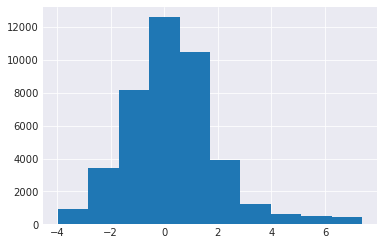

In [54]:
onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("theta")]].hist()

In [55]:
(onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("theta")]]==0.0).value_counts()

False    42327
Name: 0, dtype: int64

In [56]:
[c for c in onesample_trace.columns if c.startswith("log_gene_base")]

['log_gene_base.1',
 'log_gene_base.2',
 'log_gene_base.3',
 'log_gene_base.4',
 'log_gene_base.5',
 'log_gene_base.6',
 'log_gene_base.7',
 'log_gene_base.8',
 'log_gene_base.9',
 'log_gene_base.10',
 'log_gene_base.11',
 'log_gene_base.12',
 'log_gene_base.13',
 'log_gene_base.14',
 'log_gene_base.15',
 'log_gene_base.16',
 'log_gene_base.17',
 'log_gene_base.18',
 'log_gene_base.19',
 'log_gene_base.20',
 'log_gene_base.21',
 'log_gene_base.22',
 'log_gene_base.23',
 'log_gene_base.24',
 'log_gene_base.25',
 'log_gene_base.26',
 'log_gene_base.27',
 'log_gene_base.28',
 'log_gene_base.29',
 'log_gene_base.30',
 'log_gene_base.31',
 'log_gene_base.32',
 'log_gene_base.33',
 'log_gene_base.34',
 'log_gene_base.35',
 'log_gene_base.36',
 'log_gene_base.37',
 'log_gene_base.38',
 'log_gene_base.39',
 'log_gene_base.40',
 'log_gene_base.41',
 'log_gene_base.42',
 'log_gene_base.43',
 'log_gene_base.44',
 'log_gene_base.45',
 'log_gene_base.46',
 'log_gene_base.47',
 'log_gene_base.48',
 

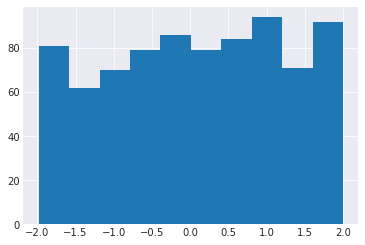

In [57]:
onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("log_gene_base")]].hist()

In [58]:
[c for c in onesample_trace.columns if c.startswith("sample2_x")]

['sample2_x.1.1',
 'sample2_x.2.1',
 'sample2_x.3.1',
 'sample2_x.4.1',
 'sample2_x.5.1',
 'sample2_x.6.1',
 'sample2_x.7.1',
 'sample2_x.8.1',
 'sample2_x.9.1',
 'sample2_x.10.1',
 'sample2_x.1.2',
 'sample2_x.2.2',
 'sample2_x.3.2',
 'sample2_x.4.2',
 'sample2_x.5.2',
 'sample2_x.6.2',
 'sample2_x.7.2',
 'sample2_x.8.2',
 'sample2_x.9.2',
 'sample2_x.10.2',
 'sample2_x.1.3',
 'sample2_x.2.3',
 'sample2_x.3.3',
 'sample2_x.4.3',
 'sample2_x.5.3',
 'sample2_x.6.3',
 'sample2_x.7.3',
 'sample2_x.8.3',
 'sample2_x.9.3',
 'sample2_x.10.3',
 'sample2_x.1.4',
 'sample2_x.2.4',
 'sample2_x.3.4',
 'sample2_x.4.4',
 'sample2_x.5.4',
 'sample2_x.6.4',
 'sample2_x.7.4',
 'sample2_x.8.4',
 'sample2_x.9.4',
 'sample2_x.10.4',
 'sample2_x.1.5',
 'sample2_x.2.5',
 'sample2_x.3.5',
 'sample2_x.4.5',
 'sample2_x.5.5',
 'sample2_x.6.5',
 'sample2_x.7.5',
 'sample2_x.8.5',
 'sample2_x.9.5',
 'sample2_x.10.5',
 'sample2_x.1.6',
 'sample2_x.2.6',
 'sample2_x.3.6',
 'sample2_x.4.6',
 'sample2_x.5.6',
 'sam

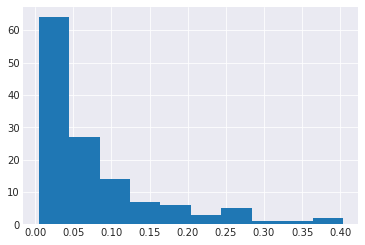

In [59]:
onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("sample2_x")]].hist()

In [60]:
(onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("sample2_x")]]==0.0).value_counts()

False    130
Name: 0, dtype: int64

In [61]:
(onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("sample2_x")]]).min()

0.0046481600000000001

In [62]:
(onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("theta")]]).abs().min()

7.1773299999999999e-05

In [63]:
7.1773299999999999e-05 * 0.0046481600000000001

3.33613782128e-07

In [64]:
np.log(3.33613782128e-07)

-14.913281853981859

In [65]:
# checks how often they have nans
print(any((onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("sample2_x")]]).isnull()))
print(any((onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("theta")]]).isnull()))
print(any((onesample_trace.iloc[0][[c for c in onesample_trace.columns if c.startswith("log_gene_base")]]).isnull()))


False
False
False


Interesting -- we couldn't find the problem in the sampling trace.

Let's dig into the issue by simplifying matters. We're going to create a temporary Stan model that sets parameters exactly to the passed-in data values, instead of creating new informative priors.

## Run for 5 iters with "set equal to passed in data" paradigm

In [67]:
# (pickle out old data)
# inject our data
informative_priors = {
    'theta_mu_mu': theta_mu_mu, 
    'theta_mu_std': theta_mu_std, 
    'theta_coefs_raw_mu': theta_coefs_raw_mu, 
    'theta_coefs_raw_std': theta_coefs_raw_std, 
    'Omega_sigma_mu': Omega_sigma_mu, 
    'Omega_sigma_std': Omega_sigma_std, 
    'log_gene_base_mu': log_gene_base_mu, 
    'log_gene_base_std': log_gene_base_std, 
    'gene_phi_mu': gene_phi_mu, 
    'gene_phi_std': gene_phi_std, 
    'theta_coefs_per_gene_mu': theta_coefs_per_gene_mu,
    'theta_coefs_per_gene_std': theta_coefs_per_gene_std,
    'Omega_L_mu': Omega_L_mu,
    'Omega_L_std': Omega_L_std
}

stan_data.update(informative_priors)


In [69]:
pickle.dump(stan_data, open('logs/tmp_2.2.standata.pkl', 'wb'))

In [73]:
# try to get pystan output in here not in terminal
# https://github.com/ipython/ipykernel/issues/111
import logging, sys

# Create logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

In [85]:
stan_data2 = {**stan_data} # copy
#stan_data2['theta_mu'] = stan_data2['theta_mu_mu']
#del stan_data2['theta_mu_mu']

# inject our data
stan_data2.update({
    'theta_mu': theta_mu_mu, 
    'theta_coefs_raw': theta_coefs_raw_mu, 
    'Omega_sigma': Omega_sigma_mu, 
    'log_gene_base': log_gene_base_mu, 
    'gene_phi': gene_phi_mu, 
    'theta_coefs_per_gene': theta_coefs_per_gene_mu,
    'Omega_L': Omega_L_mu
})


In [87]:


model_codetmp = open('models/model6.3.1_negbinom_matrix_correlation_features_oos_optim_informativepriors.stan', 'r').read()

print(pystan.stan(model_code=model_codetmp,
                  data=stan_data2,
                  iter=5,
                  chains=1,
                  verbose=True,
                  sample_file='logs/tmp_2.2_6.3.1_iter5.txt'
                 )
     )




pystan - DEBUG - Successfully parsed Stan model 'anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59'.
pystan - INFO - COMPILING THE C++ CODE FOR MODEL anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59 NOW.
pystan - INFO - OS: linux, Python: 3.6.0 | packaged by conda-forge | (default, Jan 12 2017, 00:06:14) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.25.2


Compiling /tmp/tmpd01kdkv1/stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_3681462859199124695.pyx because it changed.
[1/1] Cythonizing /tmp/tmpd01kdkv1/stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_3681462859199124695.pyx
building 'stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_3681462859199124695' extension
creating /tmp/tmpd01kdkv1/tmp
creating /tmp/tmpd01kdkv1/tmp/tmpd01kdkv1
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpd01kdkv1 -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib

ValueError: Exception: anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_namespace::anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59: Omega_L is not lower triangular; Omega_L[1,2]=0.954243  (in 'unkown file name' at line 32)


Looks like `Omega_L` is still problematic. In particular, it's supposed to be lower triangular, but isn't.

In fact we discover `Omega_L` is currently upper triangular and needs to be transposed:

In [89]:
# https://stackoverflow.com/questions/26912016/check-upper-or-lower-triangular-matrix
np.allclose(Omega_L_mu, np.tril(Omega_L_mu)) # check if lower triangular

False

In [102]:
# check if it's symmetric
np.allclose(Omega_L_mu, Omega_L_mu.T)

False

In [105]:
# correlation matrix must be positive semidefinite
# i.e. eigenvalues must be non-negative
# https://stackoverflow.com/a/17265664/130164
# https://stackoverflow.com/a/16270026/130164
import scipy
def isPSD(A, tol=1e-8):
    E,V = scipy.linalg.eigh(A)
    return np.all(E > -tol)
isPSD(Omega_L_mu)

True

In [112]:
# https://stackoverflow.com/questions/26912016/check-upper-or-lower-triangular-matrix
np.allclose(Omega_L_mu, np.triu(Omega_L_mu)) # check if upper triangular

True

In [115]:
# it was upper triangular, and now we are making it lower triangular (required because Cholesky decomposition)
Omega_L_mu = Omega_L_mu.T

In [116]:
assert np.allclose(Omega_L_mu, np.tril(Omega_L_mu)) # check if lower triangular

In [117]:
#rerun

stan_data2 = {**stan_data} # copy
#stan_data2['theta_mu'] = stan_data2['theta_mu_mu']
#del stan_data2['theta_mu_mu']

# inject our data
stan_data2.update({
    'theta_mu': theta_mu_mu, 
    'theta_coefs_raw': theta_coefs_raw_mu, 
    'Omega_sigma': Omega_sigma_mu, 
    'log_gene_base': log_gene_base_mu, 
    'gene_phi': gene_phi_mu, 
    'theta_coefs_per_gene': theta_coefs_per_gene_mu,
    'Omega_L': Omega_L_mu
})




model_codetmp = open('models/model6.3.1_negbinom_matrix_correlation_features_oos_optim_informativepriors.stan', 'r').read()

print(pystan.stan(model_code=model_codetmp,
                  data=stan_data2,
                  iter=5,
                  chains=1,
                  verbose=True,
                  sample_file='logs/tmp_2.2_6.3.1_iter5.txt'
                 )
     )




pystan - DEBUG - Successfully parsed Stan model 'anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59'.
pystan - INFO - COMPILING THE C++ CODE FOR MODEL anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59 NOW.
pystan - INFO - OS: linux, Python: 3.6.0 | packaged by conda-forge | (default, Jan 12 2017, 00:06:14) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.25.2


Compiling /tmp/tmp5sx2xle7/stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_6186754149359544596.pyx because it changed.
[1/1] Cythonizing /tmp/tmp5sx2xle7/stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_6186754149359544596.pyx
building 'stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_6186754149359544596' extension
creating /tmp/tmp5sx2xle7/tmp
creating /tmp/tmp5sx2xle7/tmp/tmp5sx2xle7
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmp5sx2xle7 -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib

ValueError: Exception: anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_namespace::anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59: Omega_L is not a valid unit vector. The sum of the squares of the elements should be 1, but is 1  (in 'unkown file name' at line 32)


Now that `Omega_L` is in the right form (lower triangular), we are seeing the error: rows don't have unit length.

https://groups.google.com/forum/#!topic/stan-dev/5iEQ9mfmXVI:
> Omega = L * L' ...  The only constraint 
> on L is that it's lower-triangular, the rows have unit length, and the 
> diagonals are positive. 

In [155]:
assert all(np.diag(Omega_L_mu) > 0) # diagonals must be positive

In [128]:
# the issue: rows are not unit length
np.linalg.norm(Omega_L_mu, axis=1)

array([ 1.        ,  1.00000022,  0.99999945,  0.99999985,  0.99999999,
        0.99999969,  0.99999994,  1.00000014,  1.00000039,  0.99999957,
        0.99999968,  1.00000021,  0.99999976])

In [135]:
# normalize the rows to unit length
from sklearn import preprocessing
Omega_L_mu_new = preprocessing.normalize(Omega_L_mu, norm='l2')
assert np.allclose(1.0,np.linalg.norm(Omega_L_mu_new, axis=1),atol=1e-16)

In [136]:
#rerun

stan_data2 = {**stan_data} # copy
#stan_data2['theta_mu'] = stan_data2['theta_mu_mu']
#del stan_data2['theta_mu_mu']

# inject our data
stan_data2.update({
    'theta_mu': theta_mu_mu, 
    'theta_coefs_raw': theta_coefs_raw_mu, 
    'Omega_sigma': Omega_sigma_mu, 
    'log_gene_base': log_gene_base_mu, 
    'gene_phi': gene_phi_mu, 
    'theta_coefs_per_gene': theta_coefs_per_gene_mu,
    'Omega_L': Omega_L_mu_new # Omega_L_mu
})




model_codetmp = open('models/model6.3.1_negbinom_matrix_correlation_features_oos_optim_informativepriors.stan', 'r').read()

print(pystan.stan(model_code=model_codetmp,
                  data=stan_data2,
                  iter=5,
                  chains=1,
                  verbose=True,
                  sample_file='logs/tmp_2.2_6.3.1_iter5.txt'
                 )
     )




pystan - DEBUG - Successfully parsed Stan model 'anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59'.
pystan - INFO - COMPILING THE C++ CODE FOR MODEL anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59 NOW.
pystan - INFO - OS: linux, Python: 3.6.0 | packaged by conda-forge | (default, Jan 12 2017, 00:06:14) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.25.2


Compiling /tmp/tmpdjwh2p85/stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_2721232323621245483.pyx because it changed.
[1/1] Cythonizing /tmp/tmpdjwh2p85/stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_2721232323621245483.pyx
building 'stanfit4anon_model_0aab9cd534d5c41e6ab56e6ebddf5e59_2721232323621245483' extension
creating /tmp/tmpdjwh2p85/tmp
creating /tmp/tmpdjwh2p85/tmp/tmpdjwh2p85
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpdjwh2p85 -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib

In [137]:
# try running with priors again now that we fixed that issue

stan_data3 = {**stan_data} # copy
stan_data3.update({
    'theta_mu_mu': theta_mu_mu, 
    'theta_mu_std': theta_mu_std, 
    'theta_coefs_raw_mu': theta_coefs_raw_mu, 
    'theta_coefs_raw_std': theta_coefs_raw_std, 
    'Omega_sigma_mu': Omega_sigma_mu, 
    'Omega_sigma_std': Omega_sigma_std, 
    'log_gene_base_mu': log_gene_base_mu, 
    'log_gene_base_std': log_gene_base_std, 
    'gene_phi_mu': gene_phi_mu, 
    'gene_phi_std': gene_phi_std, 
    'theta_coefs_per_gene_mu': theta_coefs_per_gene_mu,
    'theta_coefs_per_gene_std': theta_coefs_per_gene_std,
    'Omega_L_mu': Omega_L_mu_new, # Omega_L_mu
    'Omega_L_std': Omega_L_std
})



model_codetmp = open('models/model6.3_negbinom_matrix_correlation_features_oos_optim_informativepriors.stan', 'r').read()

print(pystan.stan(model_code=model_codetmp,
                  data=stan_data3,
                  iter=5,
                  chains=1,
                  verbose=True,
                  sample_file='logs/tmp_2.2_6.3_iter5.txt'
                 )
     )





pystan - DEBUG - Successfully parsed Stan model 'anon_model_b07e1063999ce7451a2bd7937b731c24'.
pystan - INFO - COMPILING THE C++ CODE FOR MODEL anon_model_b07e1063999ce7451a2bd7937b731c24 NOW.
pystan - INFO - OS: linux, Python: 3.6.0 | packaged by conda-forge | (default, Jan 12 2017, 00:06:14) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.25.2


Compiling /tmp/tmpu3w0rfet/stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_8181911589971257837.pyx because it changed.
[1/1] Cythonizing /tmp/tmpu3w0rfet/stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_8181911589971257837.pyx
building 'stanfit4anon_model_b07e1063999ce7451a2bd7937b731c24_8181911589971257837' extension
creating /tmp/tmpu3w0rfet/tmp
creating /tmp/tmpu3w0rfet/tmp/tmpu3w0rfet
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpu3w0rfet -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.64.0 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib

Do we need to transpose `Omega_L_std` too?

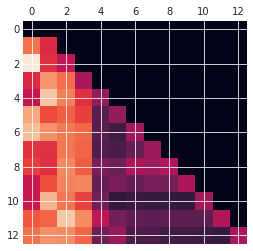

In [157]:
plt.matshow(Omega_L_std)

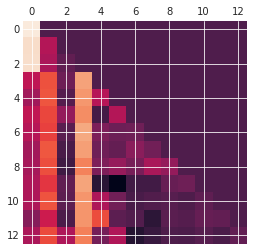

In [158]:
plt.matshow(Omega_L_mu)

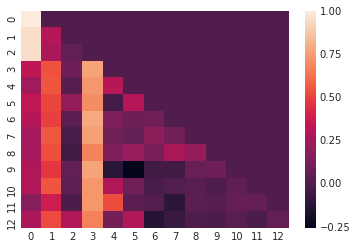

In [160]:
sns.heatmap(Omega_L_mu)

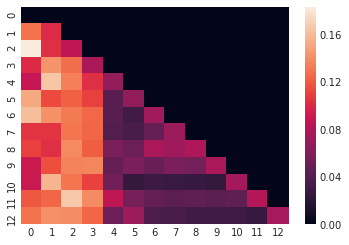

In [161]:
sns.heatmap(Omega_L_std)

No, looks like we don't need to transpose `Omega_L_std`. Variation is in the lower triangle. Good!

# Output Stan data dictionary with informative priors 

In [164]:
stan_data3 = {**stan_data} # copy
stan_data3.update({
    'theta_mu_mu': theta_mu_mu, 
    'theta_mu_std': theta_mu_std, 
    'theta_coefs_raw_mu': theta_coefs_raw_mu, 
    'theta_coefs_raw_std': theta_coefs_raw_std, 
    'Omega_sigma_mu': Omega_sigma_mu, 
    'Omega_sigma_std': Omega_sigma_std, 
    'log_gene_base_mu': log_gene_base_mu, 
    'log_gene_base_std': log_gene_base_std, 
    'gene_phi_mu': gene_phi_mu, 
    'gene_phi_std': gene_phi_std, 
    'theta_coefs_per_gene_mu': theta_coefs_per_gene_mu,
    'theta_coefs_per_gene_std': theta_coefs_per_gene_std,
    'Omega_L_mu': Omega_L_mu_new, # Omega_L_mu
    'Omega_L_std': Omega_L_std
})
stan_data3.keys()

dict_keys(['G', 'C', 'cell_features', 'M', 'N2', 'S2', 'gene2', 'sample2', 'y2', 'x2', 'theta_mu_mu', 'theta_mu_std', 'theta_coefs_raw_mu', 'theta_coefs_raw_std', 'Omega_sigma_mu', 'Omega_sigma_std', 'log_gene_base_mu', 'log_gene_base_std', 'gene_phi_mu', 'gene_phi_std', 'theta_coefs_per_gene_mu', 'theta_coefs_per_gene_std', 'Omega_L_mu', 'Omega_L_std'])

In [165]:
pickle.dump(stan_data3, open('2.2_informative_priors_standata.pkl', 'wb'))